Import some Prerequisites

In [0]:
from keras.layers import Input,Dense,Embedding,Flatten,Subtract,Concatenate
from keras.models import Model
from keras.utils import plot_model
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import numpy as np
import random

# Load datasets

load games season data and split train and test data

In [4]:
season_games = pd.read_csv('games_season.csv')
print(season_games.head())
season_X = season_games[['team_1','team_2','home']]
season_y = season_games.score_diff

   season  team_1  team_2  home  score_diff  score_1  score_2  won
0    1985    3745    6664     0          17       81       64    1
1    1985     126    7493     1           7       77       70    1
2    1985     288    3593     1           7       63       56    1
3    1985    1846    9881     1          16       70       54    1
4    1985    2675   10298     1          12       86       74    1


Load tourney data

In [5]:
tourney_games = pd.read_csv('games_tourney.csv')
print(tourney_games.head())

   season  team_1  team_2  home  seed_diff  score_diff  score_1  score_2  won
0    1985     288      73     0         -3          -9       41       50    0
1    1985    5929      73     0          4           6       61       55    1
2    1985    9884      73     0          5          -4       59       63    0
3    1985      73     288     0          3           9       50       41    1
4    1985    3920     410     0          1          -9       54       63    0


# Build a model on season games dataset
(first a model is builded as sharing multiple layer then main model is created )

Build a model to findout strength of a team using Category embedding layers

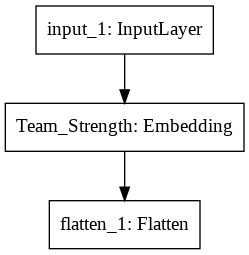

In [6]:
n_teams = np.unique(season_games.team_1).shape[0]

input_tensor = Input((1,))

embed_tensor = Embedding(input_dim=n_teams
                         ,output_dim=1
                         ,input_length=1
                         ,name='Team_Strength')(input_tensor)

flatten_tensor = Flatten()(embed_tensor)

strength_of_teams_model=Model(input_tensor,flatten_tensor,name='strength_of_teams')

plot_model(strength_of_teams_model,to_file='strength_of_teams_model.png')

Build a model to calculate diffrence between teams strength using their id's **(using last model as sharing multiple layers)**

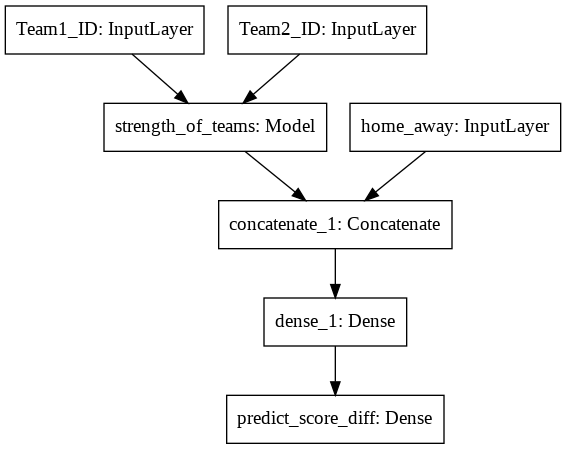

In [7]:
input_tensor_1 = Input((1,),name='Team1_ID')
input_tensor_2 = Input((1,),name='Team2_ID')
input_tensor_3 = Input((1,),name='home_away')

output_tensor_1 = strength_of_teams_model(input_tensor_1)
output_tensor_2 = strength_of_teams_model(input_tensor_2)

concated_tensor = Concatenate()([output_tensor_1,output_tensor_2,input_tensor_3])

# hiddent_tensor = Dense(5)(inputs_of_dense)

hidden_tensor = Dense(5)(concated_tensor)

output_tensor = Dense(1,name='predict_score_diff')(hidden_tensor)

season_model = Model([input_tensor_1,input_tensor_2,input_tensor_3],output_tensor)
plot_model(season_model,to_file='season_model.png')

In [8]:
season_model.summary()
season_model.compile(optimizer='adam',loss='mae')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Team1_ID (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
Team2_ID (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
strength_of_teams (Model)       (None, 1)            10888       Team1_ID[0][0]                   
                                                                 Team2_ID[0][0]                   
__________________________________________________________________________________________________
home_away (InputLayer)          (None, 1)            0                                      

# Train the season games model
(the input is team_1 and team_2 ID's and home or away the expected output is score diffrence)

In [9]:
hist= season_model.fit([season_X['team_1'],season_X['team_2'],season_X['home']]
                ,season_y
                ,epochs=50
                ,batch_size=256
                ,validation_split=0.1
                ,verbose=0
                ,callbacks =[EarlyStopping(patience=2)]
                )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


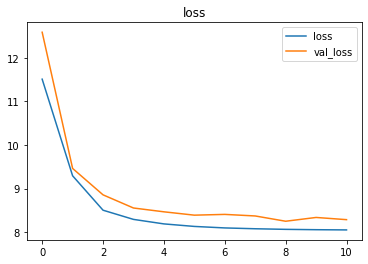

In [10]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('loss')
plt.legend(['loss','val_loss'])
plt.show()

In [11]:
season_model.evaluate([tourney_games['team_1'],tourney_games['team_2'],tourney_games['home']],tourney_games['score_diff'])

4234/4234 [==============================] - 0s 17us/step


9.038659671933008

# Build a single model for classification and regression on tourney dataset 
(season games model predictions is used as an input of tourney model "stacking models")

split games tourney dataset to train and test data

In [0]:
tourney_games['pred'] = season_model.predict([tourney_games['team_1'],tourney_games['team_2'],tourney_games['home']])
tourney_X_train, tourney_X_test, tourney_y_train , tourney_y_test = train_test_split(
    tourney_games[['seed_diff','pred']]
                 , tourney_games[['score_diff','won']]
                 , test_size=0.20)

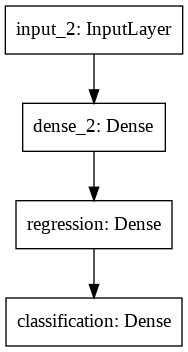

In [13]:
input_tensor = Input((2,))
hidden_tensor = Dense(5)(input_tensor)

reg_output_tensor = Dense(1,name='regression')(hidden_tensor)
class_output_tensor =Dense(1,activation='sigmoid',name='classification')(reg_output_tensor)

tourney_model = Model(input_tensor,[reg_output_tensor,class_output_tensor])

plot_model(tourney_model,to_file='tourney_model.png')

In [14]:
tourney_model.compile(optimizer='adam',loss=['mae','binary_crossentropy'])
tourney_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 15        
_________________________________________________________________
regression (Dense)           (None, 1)                 6         
_________________________________________________________________
classification (Dense)       (None, 1)                 2         
Total params: 23
Trainable params: 23
Non-trainable params: 0
_________________________________________________________________


# Train tourney model

In [0]:
hist = tourney_model.fit(tourney_X_train
                  ,[tourney_y_train.score_diff,tourney_y_train.won]
                  ,epochs =100
                  ,validation_split=0.2
                  ,verbose=0
                  ,callbacks =[EarlyStopping(patience=2)])

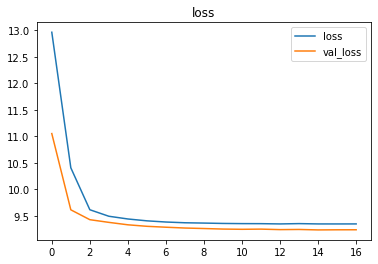

In [16]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('loss')
plt.legend(['loss','val_loss'])
plt.show()

In [17]:
tourney_model.evaluate(tourney_X_test,[tourney_y_test.score_diff,tourney_y_test.won])

847/847 [==============================] - 0s 22us/step


[9.278261574268903, 8.73940658569336, 0.5352919697761536]

# prediction Time:)

In [41]:
ind = random.randint(0,len(tourney_y_test))
print( 'input data:\n{}'.format( tourney_X_test.iloc[[ind]] ) )
print( '\nactual result =\n{}'.format( tourney_y_test.iloc[[ind]] ) )
pred = np.array(tourney_model.predict( tourney_X_test ))[:,ind,0]
predict_won = 'win' if np.round(pred[1])==1 else 'lose'
print( '\npredicted score diffrence = {} and model predicts team_1 will {} '.format(np.round(pred[0]) , predict_won) )

input data:
     seed_diff      pred
266         -3 -7.232653

actual result =
     score_diff  won
266          -8    0

predicted score diffrence = -5.0 and model predicts team_1 will lose 
